In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
# import tensorflow_docs as tfdocs
# import tensorflow_docs.plots
# import tensorflow_docs.modeling

from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, accuracy_score, recall_score,precision_score
from sklearn.preprocessing import StandardScaler, normalize

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline,Pipeline

In [ ]:
# mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1"])
mirrored_strategy = tf.distribute.MirroredStrategy(devices= ["/gpu:0","/gpu:1"],
                                                   cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
mirrored_strategy = tf.distribute.MirroredStrategy()

Num GPUs Available:  0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [ ]:
# Pour jupyter-notebook
# games_data = pd.read_csv('nba_games_data.csv', sep=';')

In [ ]:
# Pour Google colab
from google.colab import drive
drive.mount('/content/gdrive')
games_data = pd.read_csv('/content/gdrive/MyDrive/NBA/nba_games_data.csv', sep=';', encoding='latin-1')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Games Data

In [ ]:
games_data.shape
games_data.head()

,game_id,date_game,game_start_time,v_team_name,v_pts,v_record,v_field_goals,v_field_goal_attempts,v_field_goal_percentage,v_three_points_field_goals,v_three_points_field_goal_attempts,v_three_points_field_goal_percentage,v_free_throws,v_free_throw_attempts,v_free_throw_percentage,v_offensive_rebounds,v_defensive_rebounds,v_total_rebounds,v_assists,v_steals,v_blocks,v_turn_over,v_personnal_fouls,h_team_name,h_pts,h_record,h_field_goals,h_field_goal_attempts,h_field_goal_percentage,h_three_points_field_goals,h_three_points_field_goal_attempts,h_three_points_field_goal_percentage,h_free_throws,h_free_throw_attempts,h_free_throw_percentage,h_offensive_rebounds,h_defensive_rebounds,h_total_rebounds,h_assists,h_steals,h_blocks,h_turn_over,h_personnal_fouls,overtimes,attendance,game_remarks
0,b67f10f7-3459-45d3-b82e-65c6c2602441,"Tue, Dec 22, 2020",7:00p,Golden State Warriors,99.0,0-1,37.0,99.0,0.374,10.0,33.0,0.303,15.0,23.0,0.652,13.0,34.0,47.0,26.0,6.0,6.0,18.0,24.0,Brooklyn Nets,125.0,1-0,42.0,92.0,0.457,15.0,35.0,0.429,26.0,32.0,0.813,13.0,44.0,57.0,24.0,11.0,7.0,20.0,22.0,NaN,0,NaN
1,9cdcac86-1ec3-4ce3-b6a7-2496b64011b3,"Tue, Dec 22, 2020",10:00p,Los Angeles Clippers,116.0,1-0,44.0,93.0,0.473,14.0,40.0,0.350,14.0,19.0,0.737,11.0,29.0,40.0,22.0,10.0,3.0,16.0,29.0,Los Angeles Lakers,109.0,0-1,38.0,81.0,0.469,9.0,29.0,0.310,24.0,31.0,0.774,8.0,37.0,45.0,22.0,4.0,2.0,19.0,20.0,NaN,0,NaN
2,21c8f82e-3a7c-4e79-95ef-83290a1f9bd4,"Wed, Dec 23, 2020",7:00p,Charlotte Hornets,114.0,0-1,45.0,90.0,0.500,16.0,44.0,0.364,8.0,15.0,0.533,8.0,24.0,32.0,29.0,10.0,4.0,15.0,17.0,Cleveland Cavaliers,121.0,1-0,46.0,87.0,0.529,14.0,30.0,0.467,15.0,20.0,0.750,10.0,40.0,50.0,34.0,12.0,3.0,18.0,22.0,NaN,300,NaN
3,4209ddff-3f77-490b-a68d-2929fc99e334,"Wed, Dec 23, 2020",7:00p,New York Knicks,107.0,0-1,39.0,85.0,0.459,12.0,28.0,0.429,17.0,23.0,0.739,5.0,35.0,40.0,25.0,8.0,8.0,16.0,27.0,Indiana Pacers,121.0,1-0,46.0,94.0,0.489,8.0,34.0,0.235,21.0,29.0,0.724,10.0,40.0,50.0,28.0,6.0,9.0,13.0,24.0,NaN,0,NaN
4,ec1db7f3-e052-47cf-9dc5-3feaf9a4345f,"Wed, Dec 23, 2020",7:00p,Miami Heat,107.0,0-1,42.0,83.0,0.506,7.0,20.0,0.350,16.0,19.0,0.842,7.0,36.0,43.0,25.0,11.0,2.0,22.0,21.0,Orlando Magic,113.0,1-0,42.0,88.0,0.477,10.0,28.0,0.357,19.0,30.0,0.633,11.0,30.0,41.0,23.0,15.0,3.0,17.0,19.0,NaN,"3,396",NaN


In [ ]:
games_data.columns

Index(['game_id', 'date_game', 'game_start_time', 'v_team_name', 'v_pts',
       'v_record', 'v_field_goals', 'v_field_goal_attempts',
       'v_field_goal_percentage', 'v_three_points_field_goals',
       'v_three_points_field_goal_attempts',
       'v_three_points_field_goal_percentage', 'v_free_throws',
       'v_free_throw_attempts', 'v_free_throw_percentage',
       'v_offensive_rebounds', 'v_defensive_rebounds', 'v_total_rebounds',
       'v_assists', 'v_steals', 'v_blocks', 'v_turn_over', 'v_personnal_fouls',
       'h_team_name', 'h_pts', 'h_record', 'h_field_goals',
       'h_field_goal_attempts', 'h_field_goal_percentage',
       'h_three_points_field_goals', 'h_three_points_field_goal_attempts',
       'h_three_points_field_goal_percentage', 'h_free_throws',
       'h_free_throw_attempts', 'h_free_throw_percentage',
       'h_offensive_rebounds', 'h_defensive_rebounds', 'h_total_rebounds',
       'h_assists', 'h_steals', 'h_blocks', 'h_turn_over', 'h_personnal_fouls',
      

In [ ]:
games_data.describe()

,v_pts,v_field_goals,v_field_goal_attempts,v_field_goal_percentage,v_three_points_field_goals,v_three_points_field_goal_attempts,v_three_points_field_goal_percentage,v_free_throws,v_free_throw_attempts,v_free_throw_percentage,v_offensive_rebounds,v_defensive_rebounds,v_total_rebounds,v_assists,v_steals,v_blocks,v_turn_over,v_personnal_fouls,h_pts,h_field_goals,h_field_goal_attempts,h_field_goal_percentage,h_three_points_field_goals,h_three_points_field_goal_attempts,h_three_points_field_goal_percentage,h_free_throws,h_free_throw_attempts,h_free_throw_percentage,h_offensive_rebounds,h_defensive_rebounds,h_total_rebounds,h_assists,h_steals,h_blocks,h_turn_over,h_personnal_fouls
count,30073.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30073.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30071.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000
mean,98.450271,36.736632,82.280793,0.447339,7.094640,20.148144,0.347606,17.882981,23.685555,0.755741,11.007981,30.787211,41.795192,21.176443,7.590583,4.633147,14.013601,21.566274,101.473149,37.754256,82.387437,0.459219,7.247040,20.142791,0.356080,18.717977,24.719407,0.758114,11.370677,31.836027,43.206704,22.695464,7.667764,5.204742,13.717844,20.880919
std,13.122621,5.323683,7.979687,0.055589,3.911123,8.850825,0.118401,6.135830,7.579191,0.103255,3.967118,5.461299,6.486781,5.079606,2.911491,2.462737,3.955085,4.633744,13.095510,5.419221,7.951072,0.057146,3.957473,8.832595,0.120351,6.369116,7.908892,0.100052,4.089107,5.480256,6.602620,5.210258,2.957086,2.690579,3.858583,4.457062
min,53.000000,16.000000,55.000000,0.239000,0.000000,1.000000,0.000000,1.000000,1.000000,0.143000,0.000000,12.000000,20.000000,3.000000,0.000000,0.000000,2.000000,5.000000,49.000000,17.000000,51.000000,0.234000,0.000000,0.000000,0.000000,1.000000,1.000000,0.143000,1.000000,13.000000,17.000000,5.000000,0.000000,0.000000,1.000000,6.000000
25%,89.000000,33.000000,77.000000,0.410000,4.000000,14.000000,0.273000,14.000000,18.000000,0.690000,8.000000,27.000000,37.000000,18.000000,6.000000,3.000000,11.000000,18.000000,92.000000,34.000000,77.000000,0.420000,4.000000,14.000000,0.279000,14.000000,19.000000,0.696000,8.000000,28.000000,39.000000,19.000000,6.000000,3.000000,11.000000,18.000000
50%,98.000000,37.000000,82.000000,0.446000,7.000000,19.000000,0.348000,17.000000,23.000000,0.762000,11.000000,31.000000,42.000000,21.000000,7.000000,4.000000,14.000000,21.000000,101.000000,38.000000,82.000000,0.458000,7.000000,19.000000,0.357000,18.000000,24.000000,0.765000,11.000000,32.000000,43.000000,22.000000,7.000000,5.000000,14.000000,21.000000
75%,107.000000,40.000000,87.000000,0.484000,9.000000,25.000000,0.423000,22.000000,28.000000,0.826000,14.000000,34.000000,46.000000,24.000000,9.000000,6.000000,17.000000,25.000000,110.000000,41.000000,87.000000,0.500000,10.000000,25.000000,0.429000,23.000000,30.000000,0.826000,14.000000,35.000000,48.000000,26.000000,10.000000,7.000000,16.000000,24.000000
max,168.000000,63.000000,129.000000,0.674000,29.000000,63.000000,1.000000,52.000000,64.000000,1.000000,38.000000,56.000000,81.000000,46.000000,21.000000,19.000000,32.000000,42.000000,168.000000,63.000000,125.000000,0.693000,28.000000,70.000000,1.000000,48.000000,64.000000,1.000000,33.000000,55.000000,72.000000,50.000000,22.000000,23.000000,30.000000,45.000000


In [ ]:
v_teams =  games_data['v_team_name'].unique()
h_teams =  games_data['h_team_name'].unique()

teams = np.concatenate([v_teams, h_teams])
teams = np.unique(teams)

In [ ]:
teams

array(['Atlanta Hawks', 'Boston Celtics', 'Brooklyn Nets',
       'Charlotte Bobcats', 'Charlotte Hornets', 'Chicago Bulls',
       'Cleveland Cavaliers', 'Dallas Mavericks', 'Denver Nuggets',
       'Detroit Pistons', 'Golden State Warriors', 'Houston Rockets',
       'Indiana Pacers', 'Los Angeles Clippers', 'Los Angeles Lakers',
       'Memphis Grizzlies', 'Miami Heat', 'Milwaukee Bucks',
       'Minnesota Timberwolves', 'New Jersey Nets', 'New Orleans Hornets',
       'New Orleans Pelicans', 'New Orleans/Oklahoma City Hornets',
       'New York Knicks', 'Oklahoma City Thunder', 'Orlando Magic',
       'Philadelphia 76ers', 'Phoenix Suns', 'Portland Trail Blazers',
       'Sacramento Kings', 'San Antonio Spurs', 'Seattle SuperSonics',
       'Toronto Raptors', 'Utah Jazz', 'Vancouver Grizzlies',
       'Washington Wizards'], dtype=object)

In [ ]:
len(teams)

36

In [ ]:
games_data_clean = games_data.drop(columns=['game_id', 'date_game', 'game_start_time', 'game_remarks', 'attendance', 'overtimes'])
games_data_clean

,v_team_name,v_pts,v_record,v_field_goals,v_field_goal_attempts,v_field_goal_percentage,v_three_points_field_goals,v_three_points_field_goal_attempts,v_three_points_field_goal_percentage,v_free_throws,v_free_throw_attempts,v_free_throw_percentage,v_offensive_rebounds,v_defensive_rebounds,v_total_rebounds,v_assists,v_steals,v_blocks,v_turn_over,v_personnal_fouls,h_team_name,h_pts,h_record,h_field_goals,h_field_goal_attempts,h_field_goal_percentage,h_three_points_field_goals,h_three_points_field_goal_attempts,h_three_points_field_goal_percentage,h_free_throws,h_free_throw_attempts,h_free_throw_percentage,h_offensive_rebounds,h_defensive_rebounds,h_total_rebounds,h_assists,h_steals,h_blocks,h_turn_over,h_personnal_fouls
0,Golden State Warriors,99.0,0-1,37.0,99.0,0.374,10.0,33.0,0.303,15.0,23.0,0.652,13.0,34.0,47.0,26.0,6.0,6.0,18.0,24.0,Brooklyn Nets,125.0,1-0,42.0,92.0,0.457,15.0,35.0,0.429,26.0,32.0,0.813,13.0,44.0,57.0,24.0,11.0,7.0,20.0,22.0
1,Los Angeles Clippers,116.0,1-0,44.0,93.0,0.473,14.0,40.0,0.350,14.0,19.0,0.737,11.0,29.0,40.0,22.0,10.0,3.0,16.0,29.0,Los Angeles Lakers,109.0,0-1,38.0,81.0,0.469,9.0,29.0,0.310,24.0,31.0,0.774,8.0,37.0,45.0,22.0,4.0,2.0,19.0,20.0
2,Charlotte Hornets,114.0,0-1,45.0,90.0,0.500,16.0,44.0,0.364,8.0,15.0,0.533,8.0,24.0,32.0,29.0,10.0,4.0,15.0,17.0,Cleveland Cavaliers,121.0,1-0,46.0,87.0,0.529,14.0,30.0,0.467,15.0,20.0,0.750,10.0,40.0,50.0,34.0,12.0,3.0,18.0,22.0
3,New York Knicks,107.0,0-1,39.0,85.0,0.459,12.0,28.0,0.429,17.0,23.0,0.739,5.0,35.0,40.0,25.0,8.0,8.0,16.0,27.0,Indiana Pacers,121.0,1-0,46.0,94.0,0.489,8.0,34.0,0.235,21.0,29.0,0.724,10.0,40.0,50.0,28.0,6.0,9.0,13.0,24.0
4,Miami Heat,107.0,0-1,42.0,83.0,0.506,7.0,20.0,0.350,16.0,19.0,0.842,7.0,36.0,43.0,25.0,11.0,2.0,22.0,21.0,Orlando Magic,113.0,1-0,42.0,88.0,0.477,10.0,28.0,0.357,19.0,30.0,0.633,11.0,30.0,41.0,23.0,15.0,3.0,17.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30070,Chicago Bulls,93.0,01-janv,34.0,80.0,0.425,3.0,16.0,0.188,22.0,27.0,0.815,18.0,18.0,36.0,17.0,10.0,3.0,7.0,21.0,Utah Jazz,88.0,01-janv,33.0,67.0,0.493,7.0,13.0,0.538,15.0,19.0,0.789,9.0,29.0,38.0,22.0,3.0,5.0,19.0,28.0
30071,Utah Jazz,54.0,01-févr,21.0,70.0,0.300,1.0,9.0,0.111,11.0,14.0,0.786,9.0,29.0,38.0,16.0,7.0,3.0,26.0,26.0,Chicago Bulls,96.0,02-janv,37.0,76.0,0.487,4.0,11.0,0.364,18.0,26.0,0.692,11.0,39.0,50.0,25.0,13.0,5.0,17.0,19.0
30072,Utah Jazz,82.0,01-mars,33.0,78.0,0.423,2.0,15.0,0.133,14.0,21.0,0.667,13.0,27.0,40.0,24.0,6.0,1.0,10.0,32.0,Chicago Bulls,86.0,03-janv,27.0,73.0,0.370,5.0,15.0,0.333,27.0,40.0,0.675,17.0,27.0,44.0,18.0,7.0,2.0,9.0,19.0
30073,Utah Jazz,83.0,02-mars,34.0,67.0,0.507,1.0,5.0,0.200,14.0,18.0,0.778,11.0,26.0,37.0,24.0,10.0,3.0,16.0,24.0,Chicago Bulls,81.0,03-févr,29.0,75.0,0.387,7.0,20.0,0.350,16.0,20.0,0.800,13.0,20.0,33.0,19.0,11.0,5.0,16.0,25.0


### Add column v_victory and h_vitory as boolean

In [ ]:
v_victory = []
h_victory = []

for index, row in games_data_clean.iterrows():
    if row['v_pts'] > row['h_pts'] :
        v_victory.append(1)
        h_victory.append(0)
    else:
        h_victory.append(1)
        v_victory.append(0)

games_data_clean['v_victory'] = v_victory 
games_data_clean['h_victory'] = h_victory

In [ ]:
games_data_clean

,v_team_name,v_pts,v_record,v_field_goals,v_field_goal_attempts,v_field_goal_percentage,v_three_points_field_goals,v_three_points_field_goal_attempts,v_three_points_field_goal_percentage,v_free_throws,v_free_throw_attempts,v_free_throw_percentage,v_offensive_rebounds,v_defensive_rebounds,v_total_rebounds,v_assists,v_steals,v_blocks,v_turn_over,v_personnal_fouls,h_team_name,h_pts,h_record,h_field_goals,h_field_goal_attempts,h_field_goal_percentage,h_three_points_field_goals,h_three_points_field_goal_attempts,h_three_points_field_goal_percentage,h_free_throws,h_free_throw_attempts,h_free_throw_percentage,h_offensive_rebounds,h_defensive_rebounds,h_total_rebounds,h_assists,h_steals,h_blocks,h_turn_over,h_personnal_fouls,v_victory,h_victory
0,Golden State Warriors,99.0,0-1,37.0,99.0,0.374,10.0,33.0,0.303,15.0,23.0,0.652,13.0,34.0,47.0,26.0,6.0,6.0,18.0,24.0,Brooklyn Nets,125.0,1-0,42.0,92.0,0.457,15.0,35.0,0.429,26.0,32.0,0.813,13.0,44.0,57.0,24.0,11.0,7.0,20.0,22.0,0,1
1,Los Angeles Clippers,116.0,1-0,44.0,93.0,0.473,14.0,40.0,0.350,14.0,19.0,0.737,11.0,29.0,40.0,22.0,10.0,3.0,16.0,29.0,Los Angeles Lakers,109.0,0-1,38.0,81.0,0.469,9.0,29.0,0.310,24.0,31.0,0.774,8.0,37.0,45.0,22.0,4.0,2.0,19.0,20.0,1,0
2,Charlotte Hornets,114.0,0-1,45.0,90.0,0.500,16.0,44.0,0.364,8.0,15.0,0.533,8.0,24.0,32.0,29.0,10.0,4.0,15.0,17.0,Cleveland Cavaliers,121.0,1-0,46.0,87.0,0.529,14.0,30.0,0.467,15.0,20.0,0.750,10.0,40.0,50.0,34.0,12.0,3.0,18.0,22.0,0,1
3,New York Knicks,107.0,0-1,39.0,85.0,0.459,12.0,28.0,0.429,17.0,23.0,0.739,5.0,35.0,40.0,25.0,8.0,8.0,16.0,27.0,Indiana Pacers,121.0,1-0,46.0,94.0,0.489,8.0,34.0,0.235,21.0,29.0,0.724,10.0,40.0,50.0,28.0,6.0,9.0,13.0,24.0,0,1
4,Miami Heat,107.0,0-1,42.0,83.0,0.506,7.0,20.0,0.350,16.0,19.0,0.842,7.0,36.0,43.0,25.0,11.0,2.0,22.0,21.0,Orlando Magic,113.0,1-0,42.0,88.0,0.477,10.0,28.0,0.357,19.0,30.0,0.633,11.0,30.0,41.0,23.0,15.0,3.0,17.0,19.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30070,Chicago Bulls,93.0,01-janv,34.0,80.0,0.425,3.0,16.0,0.188,22.0,27.0,0.815,18.0,18.0,36.0,17.0,10.0,3.0,7.0,21.0,Utah Jazz,88.0,01-janv,33.0,67.0,0.493,7.0,13.0,0.538,15.0,19.0,0.789,9.0,29.0,38.0,22.0,3.0,5.0,19.0,28.0,1,0
30071,Utah Jazz,54.0,01-févr,21.0,70.0,0.300,1.0,9.0,0.111,11.0,14.0,0.786,9.0,29.0,38.0,16.0,7.0,3.0,26.0,26.0,Chicago Bulls,96.0,02-janv,37.0,76.0,0.487,4.0,11.0,0.364,18.0,26.0,0.692,11.0,39.0,50.0,25.0,13.0,5.0,17.0,19.0,0,1
30072,Utah Jazz,82.0,01-mars,33.0,78.0,0.423,2.0,15.0,0.133,14.0,21.0,0.667,13.0,27.0,40.0,24.0,6.0,1.0,10.0,32.0,Chicago Bulls,86.0,03-janv,27.0,73.0,0.370,5.0,15.0,0.333,27.0,40.0,0.675,17.0,27.0,44.0,18.0,7.0,2.0,9.0,19.0,0,1
30073,Utah Jazz,83.0,02-mars,34.0,67.0,0.507,1.0,5.0,0.200,14.0,18.0,0.778,11.0,26.0,37.0,24.0,10.0,3.0,16.0,24.0,Chicago Bulls,81.0,03-févr,29.0,75.0,0.387,7.0,20.0,0.350,16.0,20.0,0.800,13.0,20.0,33.0,19.0,11.0,5.0,16.0,25.0,1,0


In [ ]:
games_data_clean_visitor = games_data_clean.filter(regex='v_')
games_data_clean_home = games_data_clean.filter(regex='h_')

In [ ]:
games_data_clean_visitor

,v_team_name,v_pts,v_record,v_field_goals,v_field_goal_attempts,v_field_goal_percentage,v_three_points_field_goals,v_three_points_field_goal_attempts,v_three_points_field_goal_percentage,v_free_throws,v_free_throw_attempts,v_free_throw_percentage,v_offensive_rebounds,v_defensive_rebounds,v_total_rebounds,v_assists,v_steals,v_blocks,v_turn_over,v_personnal_fouls,v_victory
0,Golden State Warriors,99.0,0-1,37.0,99.0,0.374,10.0,33.0,0.303,15.0,23.0,0.652,13.0,34.0,47.0,26.0,6.0,6.0,18.0,24.0,0
1,Los Angeles Clippers,116.0,1-0,44.0,93.0,0.473,14.0,40.0,0.350,14.0,19.0,0.737,11.0,29.0,40.0,22.0,10.0,3.0,16.0,29.0,1
2,Charlotte Hornets,114.0,0-1,45.0,90.0,0.500,16.0,44.0,0.364,8.0,15.0,0.533,8.0,24.0,32.0,29.0,10.0,4.0,15.0,17.0,0
3,New York Knicks,107.0,0-1,39.0,85.0,0.459,12.0,28.0,0.429,17.0,23.0,0.739,5.0,35.0,40.0,25.0,8.0,8.0,16.0,27.0,0
4,Miami Heat,107.0,0-1,42.0,83.0,0.506,7.0,20.0,0.350,16.0,19.0,0.842,7.0,36.0,43.0,25.0,11.0,2.0,22.0,21.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30070,Chicago Bulls,93.0,01-janv,34.0,80.0,0.425,3.0,16.0,0.188,22.0,27.0,0.815,18.0,18.0,36.0,17.0,10.0,3.0,7.0,21.0,1
30071,Utah Jazz,54.0,01-févr,21.0,70.0,0.300,1.0,9.0,0.111,11.0,14.0,0.786,9.0,29.0,38.0,16.0,7.0,3.0,26.0,26.0,0
30072,Utah Jazz,82.0,01-mars,33.0,78.0,0.423,2.0,15.0,0.133,14.0,21.0,0.667,13.0,27.0,40.0,24.0,6.0,1.0,10.0,32.0,0
30073,Utah Jazz,83.0,02-mars,34.0,67.0,0.507,1.0,5.0,0.200,14.0,18.0,0.778,11.0,26.0,37.0,24.0,10.0,3.0,16.0,24.0,1


In [ ]:
visitor_columns = games_data_clean_visitor.columns
visitor_columns_rename = {}

for column in visitor_columns:
    visitor_columns_rename[column] = column[2:]
    
games_data_clean_visitor = games_data_clean_visitor.rename(columns=visitor_columns_rename)


In [ ]:
games_data_clean_visitor

,team_name,pts,record,field_goals,field_goal_attempts,field_goal_percentage,three_points_field_goals,three_points_field_goal_attempts,three_points_field_goal_percentage,free_throws,free_throw_attempts,free_throw_percentage,offensive_rebounds,defensive_rebounds,total_rebounds,assists,steals,blocks,turn_over,personnal_fouls,victory
0,Golden State Warriors,99.0,0-1,37.0,99.0,0.374,10.0,33.0,0.303,15.0,23.0,0.652,13.0,34.0,47.0,26.0,6.0,6.0,18.0,24.0,0
1,Los Angeles Clippers,116.0,1-0,44.0,93.0,0.473,14.0,40.0,0.350,14.0,19.0,0.737,11.0,29.0,40.0,22.0,10.0,3.0,16.0,29.0,1
2,Charlotte Hornets,114.0,0-1,45.0,90.0,0.500,16.0,44.0,0.364,8.0,15.0,0.533,8.0,24.0,32.0,29.0,10.0,4.0,15.0,17.0,0
3,New York Knicks,107.0,0-1,39.0,85.0,0.459,12.0,28.0,0.429,17.0,23.0,0.739,5.0,35.0,40.0,25.0,8.0,8.0,16.0,27.0,0
4,Miami Heat,107.0,0-1,42.0,83.0,0.506,7.0,20.0,0.350,16.0,19.0,0.842,7.0,36.0,43.0,25.0,11.0,2.0,22.0,21.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30070,Chicago Bulls,93.0,01-janv,34.0,80.0,0.425,3.0,16.0,0.188,22.0,27.0,0.815,18.0,18.0,36.0,17.0,10.0,3.0,7.0,21.0,1
30071,Utah Jazz,54.0,01-févr,21.0,70.0,0.300,1.0,9.0,0.111,11.0,14.0,0.786,9.0,29.0,38.0,16.0,7.0,3.0,26.0,26.0,0
30072,Utah Jazz,82.0,01-mars,33.0,78.0,0.423,2.0,15.0,0.133,14.0,21.0,0.667,13.0,27.0,40.0,24.0,6.0,1.0,10.0,32.0,0
30073,Utah Jazz,83.0,02-mars,34.0,67.0,0.507,1.0,5.0,0.200,14.0,18.0,0.778,11.0,26.0,37.0,24.0,10.0,3.0,16.0,24.0,1


In [ ]:
home_columns = games_data_clean_home.columns
home_columns_rename = {}

for column in home_columns:
    home_columns_rename[column] = column[2:]
    
games_data_clean_home = games_data_clean_home.rename(columns=home_columns_rename)

In [ ]:
games_data_clean_home

,team_name,pts,record,field_goals,field_goal_attempts,field_goal_percentage,three_points_field_goals,three_points_field_goal_attempts,three_points_field_goal_percentage,free_throws,free_throw_attempts,free_throw_percentage,offensive_rebounds,defensive_rebounds,total_rebounds,assists,steals,blocks,turn_over,personnal_fouls,victory
0,Brooklyn Nets,125.0,1-0,42.0,92.0,0.457,15.0,35.0,0.429,26.0,32.0,0.813,13.0,44.0,57.0,24.0,11.0,7.0,20.0,22.0,1
1,Los Angeles Lakers,109.0,0-1,38.0,81.0,0.469,9.0,29.0,0.310,24.0,31.0,0.774,8.0,37.0,45.0,22.0,4.0,2.0,19.0,20.0,0
2,Cleveland Cavaliers,121.0,1-0,46.0,87.0,0.529,14.0,30.0,0.467,15.0,20.0,0.750,10.0,40.0,50.0,34.0,12.0,3.0,18.0,22.0,1
3,Indiana Pacers,121.0,1-0,46.0,94.0,0.489,8.0,34.0,0.235,21.0,29.0,0.724,10.0,40.0,50.0,28.0,6.0,9.0,13.0,24.0,1
4,Orlando Magic,113.0,1-0,42.0,88.0,0.477,10.0,28.0,0.357,19.0,30.0,0.633,11.0,30.0,41.0,23.0,15.0,3.0,17.0,19.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30070,Utah Jazz,88.0,01-janv,33.0,67.0,0.493,7.0,13.0,0.538,15.0,19.0,0.789,9.0,29.0,38.0,22.0,3.0,5.0,19.0,28.0,0
30071,Chicago Bulls,96.0,02-janv,37.0,76.0,0.487,4.0,11.0,0.364,18.0,26.0,0.692,11.0,39.0,50.0,25.0,13.0,5.0,17.0,19.0,1
30072,Chicago Bulls,86.0,03-janv,27.0,73.0,0.370,5.0,15.0,0.333,27.0,40.0,0.675,17.0,27.0,44.0,18.0,7.0,2.0,9.0,19.0,1
30073,Chicago Bulls,81.0,03-févr,29.0,75.0,0.387,7.0,20.0,0.350,16.0,20.0,0.800,13.0,20.0,33.0,19.0,11.0,5.0,16.0,25.0,0


In [ ]:
teams_stats = pd.concat([games_data_clean_visitor, games_data_clean_home])

In [ ]:
teams_stats

,team_name,pts,record,field_goals,field_goal_attempts,field_goal_percentage,three_points_field_goals,three_points_field_goal_attempts,three_points_field_goal_percentage,free_throws,free_throw_attempts,free_throw_percentage,offensive_rebounds,defensive_rebounds,total_rebounds,assists,steals,blocks,turn_over,personnal_fouls,victory
0,Golden State Warriors,99.0,0-1,37.0,99.0,0.374,10.0,33.0,0.303,15.0,23.0,0.652,13.0,34.0,47.0,26.0,6.0,6.0,18.0,24.0,0
1,Los Angeles Clippers,116.0,1-0,44.0,93.0,0.473,14.0,40.0,0.350,14.0,19.0,0.737,11.0,29.0,40.0,22.0,10.0,3.0,16.0,29.0,1
2,Charlotte Hornets,114.0,0-1,45.0,90.0,0.500,16.0,44.0,0.364,8.0,15.0,0.533,8.0,24.0,32.0,29.0,10.0,4.0,15.0,17.0,0
3,New York Knicks,107.0,0-1,39.0,85.0,0.459,12.0,28.0,0.429,17.0,23.0,0.739,5.0,35.0,40.0,25.0,8.0,8.0,16.0,27.0,0
4,Miami Heat,107.0,0-1,42.0,83.0,0.506,7.0,20.0,0.350,16.0,19.0,0.842,7.0,36.0,43.0,25.0,11.0,2.0,22.0,21.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30070,Utah Jazz,88.0,01-janv,33.0,67.0,0.493,7.0,13.0,0.538,15.0,19.0,0.789,9.0,29.0,38.0,22.0,3.0,5.0,19.0,28.0,0
30071,Chicago Bulls,96.0,02-janv,37.0,76.0,0.487,4.0,11.0,0.364,18.0,26.0,0.692,11.0,39.0,50.0,25.0,13.0,5.0,17.0,19.0,1
30072,Chicago Bulls,86.0,03-janv,27.0,73.0,0.370,5.0,15.0,0.333,27.0,40.0,0.675,17.0,27.0,44.0,18.0,7.0,2.0,9.0,19.0,1
30073,Chicago Bulls,81.0,03-févr,29.0,75.0,0.387,7.0,20.0,0.350,16.0,20.0,0.800,13.0,20.0,33.0,19.0,11.0,5.0,16.0,25.0,0


In [ ]:
teams_stats_by_team_name = teams_stats.groupby('team_name').mean()
teams_stats_by_team_name

,pts,field_goals,field_goal_attempts,field_goal_percentage,three_points_field_goals,three_points_field_goal_attempts,three_points_field_goal_percentage,free_throws,free_throw_attempts,free_throw_percentage,offensive_rebounds,defensive_rebounds,total_rebounds,assists,steals,blocks,turn_over,personnal_fouls,victory
team_name,,,,,,,,,,,,,,,,,,,
Atlanta Hawks,98.410500,36.666000,81.656500,0.449739,7.089000,20.154500,0.346430,17.989500,23.652000,0.760054,11.083000,30.973500,42.056500,21.682500,7.630500,4.900500,14.358500,20.725500,0.454500
Boston Celtics,99.771930,36.902323,81.755334,0.452642,7.788051,21.917022,0.352323,18.179232,23.741584,0.766676,10.421053,31.215268,41.636321,22.287340,8.366050,4.510669,14.107634,22.416785,0.538170
Brooklyn Nets,104.724734,38.378989,84.724734,0.454066,10.158245,28.663564,0.351468,17.808511,23.448138,0.760449,10.171543,33.301862,43.473404,22.547872,7.085106,4.410904,14.134309,20.093085,0.446809
Charlotte Bobcats,94.541872,35.333744,80.201970,0.441732,5.387931,15.582512,0.342869,18.486453,25.116995,0.734869,10.977833,29.477833,40.455665,21.025862,7.427340,5.096059,13.747537,21.052956,0.360837
Charlotte Hornets,100.396891,36.727461,82.933679,0.443948,7.866321,22.190674,0.350706,19.075648,25.020725,0.763638,10.664249,32.555440,43.219689,22.786528,7.561658,4.979275,12.959585,19.401036,0.499482
Chicago Bulls,96.863342,36.473317,82.680299,0.442042,6.457357,18.232918,0.350056,17.459352,23.195511,0.753606,11.743142,31.661347,43.404489,22.189027,7.423441,4.917706,14.237905,21.175062,0.462344
Cleveland Cavaliers,98.671059,36.612006,81.582723,0.449717,7.104929,19.832601,0.351267,18.342118,24.560761,0.746748,11.463153,31.162518,42.625671,21.546608,7.370913,4.608590,13.964861,20.920449,0.484139
Dallas Mavericks,102.190569,37.968872,83.347276,0.456464,8.076848,22.321984,0.362427,18.181907,23.046693,0.788643,10.719844,31.622082,42.341926,21.600195,7.311284,4.906128,12.541342,20.712062,0.565873
Denver Nuggets,102.618118,38.086086,83.865365,0.454775,7.099099,20.304805,0.341429,19.346847,25.739740,0.751730,11.910911,31.396396,43.307307,23.173173,7.979479,5.355355,14.297798,21.836336,0.498999


In [ ]:
first_column = teams_stats.pop('victory')
  
# insert column using insert(position,column_name,
# first_column) function
teams_stats.insert(0, 'victory', first_column)

In [ ]:
teams_stats

,victory,team_name,pts,record,field_goals,field_goal_attempts,field_goal_percentage,three_points_field_goals,three_points_field_goal_attempts,three_points_field_goal_percentage,free_throws,free_throw_attempts,free_throw_percentage,offensive_rebounds,defensive_rebounds,total_rebounds,assists,steals,blocks,turn_over,personnal_fouls
0,0,Golden State Warriors,99.0,0-1,37.0,99.0,0.374,10.0,33.0,0.303,15.0,23.0,0.652,13.0,34.0,47.0,26.0,6.0,6.0,18.0,24.0
1,1,Los Angeles Clippers,116.0,1-0,44.0,93.0,0.473,14.0,40.0,0.350,14.0,19.0,0.737,11.0,29.0,40.0,22.0,10.0,3.0,16.0,29.0
2,0,Charlotte Hornets,114.0,0-1,45.0,90.0,0.500,16.0,44.0,0.364,8.0,15.0,0.533,8.0,24.0,32.0,29.0,10.0,4.0,15.0,17.0
3,0,New York Knicks,107.0,0-1,39.0,85.0,0.459,12.0,28.0,0.429,17.0,23.0,0.739,5.0,35.0,40.0,25.0,8.0,8.0,16.0,27.0
4,0,Miami Heat,107.0,0-1,42.0,83.0,0.506,7.0,20.0,0.350,16.0,19.0,0.842,7.0,36.0,43.0,25.0,11.0,2.0,22.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30070,0,Utah Jazz,88.0,01-janv,33.0,67.0,0.493,7.0,13.0,0.538,15.0,19.0,0.789,9.0,29.0,38.0,22.0,3.0,5.0,19.0,28.0
30071,1,Chicago Bulls,96.0,02-janv,37.0,76.0,0.487,4.0,11.0,0.364,18.0,26.0,0.692,11.0,39.0,50.0,25.0,13.0,5.0,17.0,19.0
30072,1,Chicago Bulls,86.0,03-janv,27.0,73.0,0.370,5.0,15.0,0.333,27.0,40.0,0.675,17.0,27.0,44.0,18.0,7.0,2.0,9.0,19.0
30073,0,Chicago Bulls,81.0,03-févr,29.0,75.0,0.387,7.0,20.0,0.350,16.0,20.0,0.800,13.0,20.0,33.0,19.0,11.0,5.0,16.0,25.0


In [ ]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    


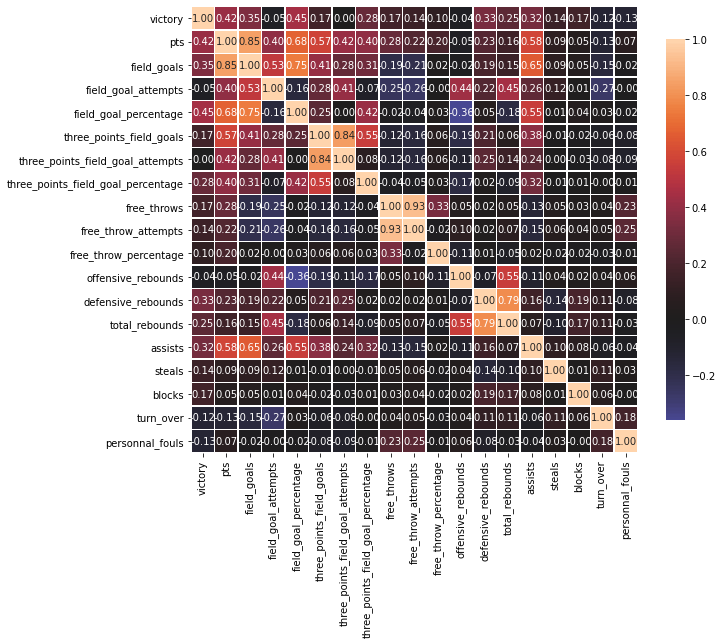

In [ ]:
correlation_heatmap(teams_stats)

In [ ]:
# plt.figure(figsize=(15,15))
# sns.heatmap(teams_stats.corr())
# plt.title('Correlation in the data')
# plt.show()

In [ ]:
corrMatrix = teams_stats.corr()
corrMatrix['victory'].sort_values(ascending=False) 

victory                               1.000000
field_goal_percentage                 0.445418
pts                                   0.416591
field_goals                           0.348003
defensive_rebounds                    0.331635
assists                               0.324453
three_points_field_goal_percentage    0.283801
total_rebounds                        0.252551
free_throws                           0.171574
three_points_field_goals              0.169380
blocks                                0.167855
free_throw_attempts                   0.143018
steals                                0.141243
free_throw_percentage                 0.100031
three_points_field_goal_attempts      0.001597
offensive_rebounds                   -0.039701
field_goal_attempts                  -0.052758
turn_over                            -0.122421
personnal_fouls                      -0.129532
Name: victory, dtype: float64

In [ ]:
# corrMatrix['victory'].sort_values(ascending=False) < 0.1 or corrMatrix['victory'].sort_values(ascending=False) < -0.1

In [ ]:
# df = teams_stats.loc[corrMatrix['victory'].sort_values(ascending=False) < 0]
# df

# teams_stats[corrMatrix['victory'].sort_values(ascending=False) < 0]

In [ ]:
teams_stats = teams_stats.drop(columns=['offensive_rebounds', 'field_goal_attempts', 'three_points_field_goal_attempts'])

In [ ]:
teams_stats = teams_stats.drop(columns=['team_name', 'record'])

In [ ]:
teams_stats

,victory,pts,field_goals,field_goal_percentage,three_points_field_goals,three_points_field_goal_percentage,free_throws,free_throw_attempts,free_throw_percentage,defensive_rebounds,total_rebounds,assists,steals,blocks,turn_over,personnal_fouls
0,0,99.0,37.0,0.374,10.0,0.303,15.0,23.0,0.652,34.0,47.0,26.0,6.0,6.0,18.0,24.0
1,1,116.0,44.0,0.473,14.0,0.350,14.0,19.0,0.737,29.0,40.0,22.0,10.0,3.0,16.0,29.0
2,0,114.0,45.0,0.500,16.0,0.364,8.0,15.0,0.533,24.0,32.0,29.0,10.0,4.0,15.0,17.0
3,0,107.0,39.0,0.459,12.0,0.429,17.0,23.0,0.739,35.0,40.0,25.0,8.0,8.0,16.0,27.0
4,0,107.0,42.0,0.506,7.0,0.350,16.0,19.0,0.842,36.0,43.0,25.0,11.0,2.0,22.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30070,0,88.0,33.0,0.493,7.0,0.538,15.0,19.0,0.789,29.0,38.0,22.0,3.0,5.0,19.0,28.0
30071,1,96.0,37.0,0.487,4.0,0.364,18.0,26.0,0.692,39.0,50.0,25.0,13.0,5.0,17.0,19.0
30072,1,86.0,27.0,0.370,5.0,0.333,27.0,40.0,0.675,27.0,44.0,18.0,7.0,2.0,9.0,19.0
30073,0,81.0,29.0,0.387,7.0,0.350,16.0,20.0,0.800,20.0,33.0,19.0,11.0,5.0,16.0,25.0


In [ ]:
corrMatrix = teams_stats.corr()
corrMatrix['victory'].sort_values(ascending=False) 

victory                               1.000000
field_goal_percentage                 0.445418
pts                                   0.416591
field_goals                           0.348003
defensive_rebounds                    0.331635
assists                               0.324453
three_points_field_goal_percentage    0.283801
total_rebounds                        0.252551
free_throws                           0.171574
three_points_field_goals              0.169380
blocks                                0.167855
free_throw_attempts                   0.143018
steals                                0.141243
free_throw_percentage                 0.100031
turn_over                            -0.122421
personnal_fouls                      -0.129532
Name: victory, dtype: float64

In [ ]:
X = teams_stats['victory']
Y = teams_stats['field_goal_percentage']

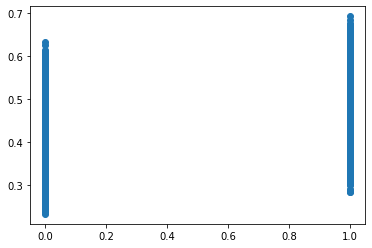

In [ ]:
plt.scatter(X,Y)
plt.show()

### Il y a des valeurs manquantes

In [ ]:
print("Nombre de valeurs nulles : " + str(teams_stats.isnull().sum().sum()))

Nombre de valeurs nulles : 89


In [ ]:
teams_stats.isna().sum()

victory                               0
pts                                   4
field_goals                           6
field_goal_percentage                 6
three_points_field_goals              6
three_points_field_goal_percentage    7
free_throws                           6
free_throw_attempts                   6
free_throw_percentage                 6
defensive_rebounds                    6
total_rebounds                        6
assists                               6
steals                                6
blocks                                6
turn_over                             6
personnal_fouls                       6
dtype: int64

In [ ]:
teams_stats = teams_stats.dropna()

In [ ]:
print("Nombre de valeurs nulles : " + str(teams_stats.isnull().sum().sum()))

Nombre de valeurs nulles : 0


In [ ]:
# plt.figure(figsize=(4,8))
# colors = ["0", "1"]
# sns.countplot(x=teams_stats['victory'], palette = "Set2")
# plt.title('Stars Distribution \n (0: Match perdus || 1: Matchs gagnés)', fontsize=14)

## Test d'algo

In [ ]:
from sklearn.model_selection import train_test_split

# train_data, test_data = train_test_split(teams_stats, test_size=0.2)

In [ ]:
# len(train_data)

In [ ]:
# len(test_data)

In [ ]:
# X_train = train_data.drop(["victory"],axis=1)
# y_train = train_data["victory"]   
# X_test = test_data.drop(["victory"],axis=1)
# y_test = test_data["victory"]

In [ ]:
X = teams_stats.drop('victory', axis=1)  
y = teams_stats['victory']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

#### Normalize

In [ ]:
X_train = normalize(X_train)
X_test = normalize(X_test)

#### Feature scaling

In [ ]:
std_scaler = StandardScaler()
X_train = scaled = std_scaler.fit_transform(X_train)
X_test = std_scaler.fit_transform(X_test)

### Les modèles

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Decision tree

In [ ]:
model_DT = DecisionTreeClassifier(random_state=1)

In [ ]:
model_DT.fit(X_train, y_train)
print(model_DT.__class__.__name__, model_DT.score(X_test, y_test))
print(confusion_matrix(y_test, model_DT.predict(X_test)))

DecisionTreeClassifier 0.6334691163022695
[[3809 2184]
 [2225 3811]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

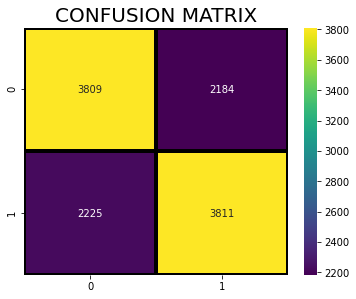

In [ ]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_DT.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

## KNN

In [ ]:
model_KNN = KNeighborsClassifier(n_jobs=-1)

In [ ]:
model_KNN.fit(X_train, y_train)
print(model_KNN.__class__.__name__, model_KNN.score(X_test, y_test))
print(confusion_matrix(y_test, model_KNN.predict(X_test)))

KNeighborsClassifier 0.6796907473605454
[[3915 2078]
 [1775 4261]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

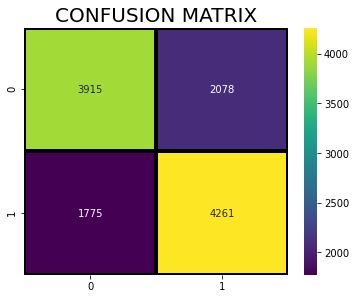

In [ ]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_KNN.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

## Random Forest

In [ ]:
model_RF = RandomForestClassifier(n_jobs=-1)

In [ ]:
model_RF.fit(X_train, y_train)
print(model_RF.__class__.__name__, model_RF.score(X_test, y_test))
print(confusion_matrix(y_test, model_RF.predict(X_test)))

RandomForestClassifier 0.7304015296367112
[[4432 1561]
 [1682 4354]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

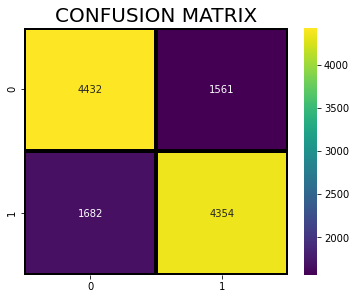

In [ ]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_RF.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

## Regression

In [ ]:
model_LR = LogisticRegression(n_jobs=-1)

In [ ]:
model_LR.fit(X_train, y_train)
print(model_LR.__class__.__name__, model_LR.score(X_test, y_test))
print(confusion_matrix(y_test, model_LR.predict(X_test)))

LogisticRegression 0.8122869731482252
[[4885 1108]
 [1150 4886]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

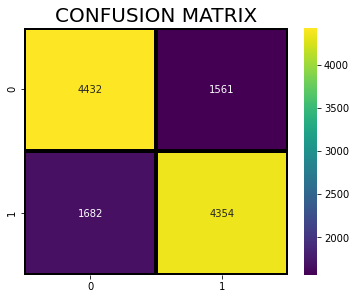

In [ ]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_RF.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

## Support Vector Machine

In [ ]:
model_SVC = SVC()

In [ ]:
model_SVC.fit(X_train, y_train)
print(model_SVC.__class__.__name__, model_SVC.score(X_test, y_test))
print(confusion_matrix(y_test, model_SVC.predict(X_test)))

SVC 0.8393050128855266
[[5086  907]
 [1026 5010]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

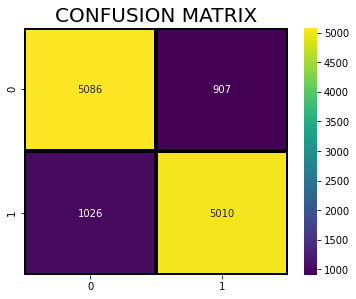

In [ ]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_SVC.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#### Trop lent !

In [ ]:
# kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']#A function which returns the corresponding SVC model
# def getClassifier(ktype):
#     if ktype == 0:
#         # Polynomial kernal
#         return SVC(kernel='poly', degree=8, gamma="auto")
#     elif ktype == 1:
#         # Radial Basis Function kernal
#         return SVC(kernel='rbf', gamma="auto")
#     elif ktype == 2:
#         # Sigmoid kernal
#         return SVC(kernel='sigmoid', gamma="auto")
#     elif ktype == 3:
#         # Linear kernal
#         return SVC(kernel='linear', gamma="auto")

# for i in range(2):
#     # Separate data into test and training sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)# Train a SVC model using different kernal
#     svclassifier = getClassifier(i) 
#     svclassifier.fit(X_train, y_train)# Make prediction
#     y_pred = svclassifier.predict(X_test)# Evaluate our model
#     print("Evaluation:", kernals[i], "kernel")
#     print(classification_report(y_test,y_pred))

In [ ]:
# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

#### Après divers test un gamma de 0.01 semble le plus efficace

In [ ]:
# param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']} 

# param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [ 0.01],
#               'kernel': ['rbf']} 
              
# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# # fitting the model for grid search
# grid.fit(X_train, y_train)

In [ ]:
# print(grid.best_estimator_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# grid_predictions = grid.predict(X_test)
# print(confusion_matrix(y_test,grid_predictions))
# print(classification_report(y_test,grid_predictions))#Output

In [ ]:
model_SVC_2 = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
model_SVC_2.fit(X_train, y_train)
print(model_SVC_2.__class__.__name__, model_SVC_2.score(X_test, y_test))
print(confusion_matrix(y_test, model_SVC_2.predict(X_test)))

SVC 0.8472025937318148
[[5120  873]
 [ 965 5071]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

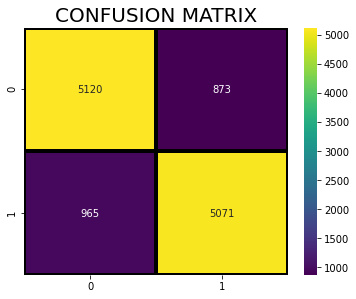

In [ ]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_SVC_2.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

In [ ]:
!pip install scikit-optimize
import skopt

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
 
# define the space of hyperparameters to search
search_space = list()
search_space.append(Real(1e-6, 100.0, 'log-uniform', name='C'))
search_space.append(Categorical(['linear', 'poly', 'rbf', 'sigmoid'], name='kernel'))
search_space.append(Integer(1, 5, name='degree'))
search_space.append(Real(1e-6, 100.0, 'log-uniform', name='gamma'))
 
# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
	# configure the model with specific hyperparameters
	model = SVC()
	model.set_params(**params)
	# define test harness
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# calculate 5-fold cross validation
	result = cross_val_score(model, X, y, cv=cv, n_jobs=-1, scoring='accuracy', verbose=3)
	# calculate the mean of the scores
	estimate = mean(result)
	# convert from a maximizing score to a minimizing score
	return 1.0 - estimate
 
# # load dataset
# url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.csv'
# dataframe = read_csv(url, header=None)
# # split into input and output elements
# data = dataframe.values
# X, y = data[:, :-1], data[:, -1]
print(X.shape, y.shape)
# perform optimization
result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: %s' % (result.x))

(60143, 15) (60143,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 46.5min finished


NameError: ignored

#### On essaye le linearSVC

In [ ]:
model_SVC = LinearSVC(random_state=0, tol=1e-5, max_iter=5000)

In [ ]:
model_SVC.fit(X_train, y_train)
print(model_SVC.__class__.__name__, model_SVC.score(X_test, y_test))
print(confusion_matrix(y_test, model_SVC.predict(X_test)))

In [ ]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_SVC.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#### Mieux mais moins efficace

## GridSearchCV

### Logistic regression

In [ ]:
param_grid={'penalty': ['none', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
      
grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

In [ ]:
print(grid.best_estimator_)

In [ ]:
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

### Random Forest

In [ ]:
rfc=RandomForestClassifier(random_state=42)

In [ ]:
# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy']
# }

In [ ]:
# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, verbose=2)
# CV_rfc.fit(X_train, y_train)

In [ ]:
# CV_rfc.best_params_

"{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}"

In [ ]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 500, max_depth=8, criterion='gini')

In [ ]:
rfc1.fit(X_train, y_train)

In [ ]:
pred=rfc1.predict(X_test)

In [ ]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

In [ ]:
param_grid = {'C': [0.001,0.1,1, 10, 100]}

grid = GridSearchCV(LinearSVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

In [ ]:
print(grid.best_estimator_)

In [ ]:
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))